In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import random as rn
import csv
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# tensorflowの乱数シード固定(再現性の担保)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
batch_size = 32
n_epochs = 50

# 画像データ取り込み


In [4]:
DATA_FOLDER = '../data/'
datalist = pd.read_csv(os.path.join(DATA_FOLDER, 'frames_data.csv'), names=["img_path", "l_class", 's_class','timestamp'])
datalist.head()

,img_path,l_class,s_class,timestamp
0,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
1,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
2,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
3,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
4,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43


In [5]:
l_classlist = ['4gokan', '5gokan', '5gokan-denkisogokan', '5gokan-mediacenter'
                    '8gokan', 'denkisogokan', 'lab', 'lab-lounge', 'lounge']
s_classlist = ['4gokan_inside', '4gokan_outside', '5gokan-denkisogokan', '5gokan-mediacenter',
'5gokan_1F', '5gokan_2F', '5gokan_3F', '5gokan_ent_east', '5gokan_lounge',
'5gokan_out_east', '5gokan_parking', '5gokan_smoking', '5gokan_stairs_cnt',
'5gokan_stairs_west', '8gokan_1F', '8gokan_ent_north', '8gokan_ent_south',
'denkisogokan_2F', 'denkisogokan_3F', 'denkisogokan_4F', 'denkisogokan_elevator',
'denkisogokan_lounge', 'denkisogokan_stairs', 'lab-lounge', 'lab_bs_cnt',
'lab_corner', 'lab_desk', 'lab_desk_table', 'lab_ent', 'lab_printer',
'lab_table', 'lab_wb_cnt', 'lab_wb_ent', 'lounge']
num_l_class =len(l_classlist)
num_s_class = len(s_classlist)

In [6]:
print(num_s_class)

34


In [7]:
dfl = datalist.drop(['s_class','timestamp'], axis=1)
dfl.head()

,img_path,l_class
0,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
1,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
2,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
3,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
4,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan


In [8]:
dfl.groupby('l_class').count()

,img_path
l_class,
4gokan,308
5gokan,1328
5gokan-denkisogokan,361
5gokan-mediacenter,127
8gokan,266
denkisogokan,523
lab,1953
lab-lounge,63
lounge,247


In [9]:
dfs = datalist.drop(['l_class', 'timestamp'], axis=1)
dfs.groupby('s_class').count()

,img_path
s_class,
4gokan_inside,60
4gokan_outside,248
5gokan-denkisogokan,361
5gokan-mediacenter,127
5gokan_1F,65
5gokan_2F,96
5gokan_3F,32
5gokan_ent_east,135
5gokan_lounge,361


In [10]:
grad_test_img_path =[
    "../data/insta_frames/4gokan/4gokan_inside/4gokan_inside_0_img_000030.png",
    "../data/insta_frames/4gokan/4gokan_outside/4gokan_outside_0_img_000030.png",
    "../data/insta_frames/5gokan-denkisogokan/5gokan-denkisogokan_0_img_000030.png",
    "../data/insta_frames/5gokan-mediacenter/5gokan-mediacenter_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_1F/5gokan_1F_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_2F/5gokan_2F_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_3F/5gokan_3F_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_ent_east/5gokan_ent_east_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_lounge/5gokan_lounge_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_out_east/5gokan_out_east_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_parking/5gokan_parking_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_smoking/5gokan_smoking_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_stairs_cnt/5gokan_stairs_cnt_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_stairs_west/5gokan_stairs_west_0_img_000030.png",
    "../data/insta_frames/8gokan/8gokan_1F/8gokan_1F_0_img_000030.png",
    "../data/insta_frames/8gokan/8gokan_ent_north/8gokan_ent_north_0_img_000030.png",
    "../data/insta_frames/8gokan/8gokan_ent_south/8gokan_ent_south_1_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_2F/denkisogokan_2F_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_3F/denkisogokan_3F_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_4F/denkisogokan_4F_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_elevator/denkisogokan_elevator_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_lounge/denkisogokan_lounge_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_stairs/denkisogokan_stairs_0_img_000030.png",
    "../data/insta_frames/lab-lounge/lab-lounge_0_img_000030.png",
    "../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt_0_img_000030.png",
    "../data/insta_frames/lab/lab_corner/lab_corner_0_img_000030.png",
    "../data/insta_frames/lab/lab_desk/lab_desk_0_img_000030.png",
    "../data/insta_frames/lab/lab_desk_table/lab_desk_table_0_img_000030.png",
    "../data/insta_frames/lab/lab_ent/lab_ent_0_img_000030.png",
    "../data/insta_frames/lab/lab_printer/lab_printer_0_img_000030.png",
    "../data/insta_frames/lab/lab_table/lab_table_0_img_000030.png",
    "../data/insta_frames/lab/lab_wb_cnt/lab_wb_cnt_0_img_000030.png",
    "../data/insta_frames/lab/lab_wb_ent/lab_wb_ent_0_img_000030.png",
    "../data/insta_frames/lounge/lounge_0_img_000030.png",
]

# Markdown
from sklearn.preprocessing import LabelEncoder

# Markdown
le = LabelEncoder()
le.fit(dfs.s_class)
dfs["labels"] = le.transform(dfs.s_class)
dfs.groupby('labels')

# Markdown
cor_table = dfs.groupby('labels').s_class.unique()
cor_table = pd.DataFrame(cor_table)
cor_table.head()

# Markdown
cor_table.to_csv('cor_table.csv', index=False)

# Markdown
dfs = dfs.drop(['s_class'], axis=1)

# Markdown
x = []
for i in range(len(dfs.img_path)):
    image = img_to_array(load_img(dfs.img_path[i], target_size=(224,224)))
    x.append(image)

# Markdown
y = dfs.labels
print(y)

# Markdown
#正規化
x = np.array(x, dtype='float32')/255

# Markdown
#np.array形式のデータを保存　x, y
np.save(file='x.npy', arr=x)
np.save(file='y.npy', arr=y)

In [11]:
#x, yをload
x = np.load(file='x.npy')
y = np.load(file='y.npy')

In [12]:
print(x.shape)
print(y.shape)

(5176, 224, 224, 3)
(5176,)


# train test & validation set split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x, x_valid, y, y_valid = train_test_split(x,y, random_state=42, test_size=0.2, stratify=y)

# EDA(探索的データ解析)


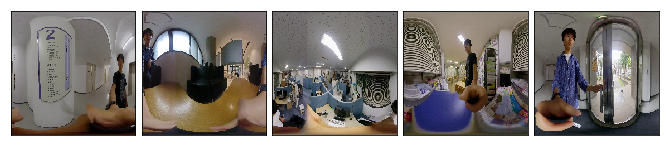

In [15]:
fig = plt.figure(figsize=(9,18))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x[i])

# Inception v3 (Pretrained ImageNet)

In [16]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, add, Add, Dropout, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [18]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

inputs = Input(shape=(224,224,3))
x1 = base_model(inputs)
x2 = Flatten()(x1)
x3 = Dense(256, activation='relu')(x2)
prediction = Dense(num_s_class, activation='softmax')(x3)
full_model = Model(inputs=inputs, outputs=prediction)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
for layer in model.layers[:249]:
    layer.trainable = False
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [20]:
x1 = base_model.output

x2 = GlobalAveragePooling2D()(x1)
x3 = Dense(1024, activation='relu')(x2)
prediction = Dense(num_s_class, activation='softmax')(x3)
full_model = Model(inputs=base_model.input, outputs=prediction)

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
for layer in full_model.layers[:249]:
    layer.trainable = False
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
for layer in full_model.layers[249:]:
    layer.trainable = True  
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

top(全結合層など)はデフォルトだとImageNetの全クラス数1000での出力になるので，
自作のアーキテクチャを使用する
top以外のモデルの重みは(ImageNetで)固定しない→学習をする

Fine-tuning(Flozen(Not training InceptionV3 layers))

   # 層化抽出法(Stratified sampling)&KFold

In [22]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils

Using TensorFlow backend.


In [23]:
skf = StratifiedKFold(n_splits=5, random_state=42)
cvscores = []
#Stratified KFoldはlabel encoding化した整数ベクトルでないともちいることができない
x = np.array(x)
y = np.array(y)
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #One-hot化　CNNに入出力できるように整形
    y_train = np_utils.to_categorical(y_train, num_s_class)
    y_test = np_utils.to_categorical(y_test, num_s_class)
    full_model.fit(x_train, y_train, verbose=1, batch_size=batch_size, epochs=n_epochs,
              callbacks=[early_stopping], validation_split=0.2)
    scores = full_model.evaluate(x_test, y_test)
    print("%s: %.2f%%" % (full_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Train on 2639 samples, validate on 660 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2639/2639 [==============================] - 19s 7ms/sample - loss: 0.8971 - acc: 0.7723 - val_loss: 4.0813 - val_acc: 0.6091
Epoch 2/50
2639/2639 [==============================] - 12s 4ms/sample - loss: 0.1461 - acc: 0.9598 - val_loss: 0.7490 - val_acc: 0.8712
Epoch 3/50
2639/2639 [==============================] - 12s 5ms/sample - loss: 0.0680 - acc: 0.9822 - val_loss: 0.4620 - val_acc: 0.9045
Epoch 4/50
2639/2639 [==============================] - 12s 5ms/sample - loss: 0.0568 - acc: 0.9864 - val_loss: 4.2072 - val_acc: 0.6106
Epoch 00004: early stopping
841/841 [==============================] - 1s 2ms/sample - loss: 4.4445 - acc: 0.5945
acc: 59.45%
Train on 2645 samples, validate on 662 samples
Epoch 1/50
2645/2645 [==============================] - 13s 5ms/sample - loss: 0.0974 - acc: 0.9713 - val_loss: 0.4771 - val_acc: 0.9199
Epoch 2/50
2645/2645 [=========================

In [24]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

88.24% (+/- 15.26%)


In [25]:
y_pred = full_model.predict(x_valid)

In [26]:
y_valid = np_utils.to_categorical(y_valid)

In [27]:
y_pred = np.array(y_pred)
y_true = np.array(y_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csgraph import connected_components

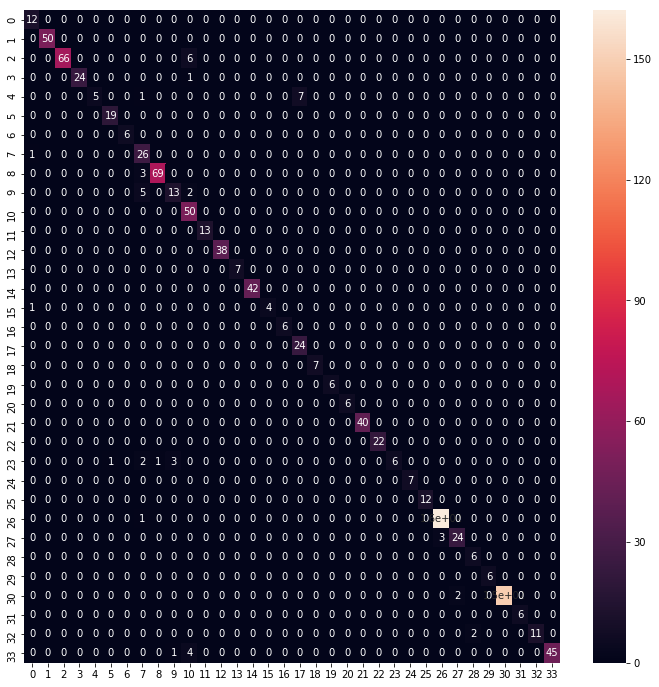

accuracy: 0.9546332046332047


In [29]:
cmx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred)))

In [30]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

                      s_class
0           ['4gokan_inside']
1          ['4gokan_outside']
2     ['5gokan-denkisogokan']
3      ['5gokan-mediacenter']
4               ['5gokan_1F']
5               ['5gokan_2F']
6               ['5gokan_3F']
7         ['5gokan_ent_east']
8           ['5gokan_lounge']
9         ['5gokan_out_east']
10         ['5gokan_parking']
11         ['5gokan_smoking']
12      ['5gokan_stairs_cnt']
13     ['5gokan_stairs_west']
14              ['8gokan_1F']
15       ['8gokan_ent_north']
16       ['8gokan_ent_south']
17        ['denkisogokan_2F']
18        ['denkisogokan_3F']
19        ['denkisogokan_4F']
20  ['denkisogokan_elevator']
21    ['denkisogokan_lounge']
22    ['denkisogokan_stairs']
23             ['lab-lounge']
24             ['lab_bs_cnt']
25             ['lab_corner']
26               ['lab_desk']
27         ['lab_desk_table']
28                ['lab_ent']
29            ['lab_printer']
30              ['lab_table']
31             ['lab_wb_cnt']
32        

#  最終層の特徴ベクトル 

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [32]:
pca = PCA()

In [33]:
cm_name = 'jet'
cmap = plt.get_cmap(cm_name, num_s_class)

In [34]:
# one-hotから整数値ベクトルに変換
y_train_vec = []
for i in range(len(y_train)):
    y_train_vec.append(np.argmax(y_train[i]))

In [35]:
x_last = base_model.get_layer('mixed10').output
output_last = GlobalMaxPooling2D()(x_last)
model_last = Model(inputs=base_model.input, outputs=output_last)

In [36]:
last_feature = model_last.predict(x_train)

In [37]:
print(last_feature.shape)

(3325, 2048)


In [38]:
last_pca = pca.fit_transform(last_feature)

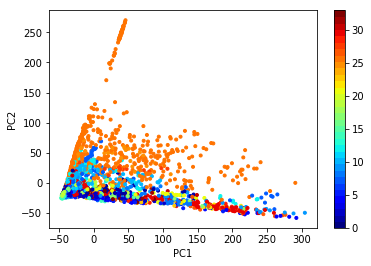

In [39]:
plt.scatter(last_pca[:,0],last_pca[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

In [40]:
from mpl_toolkits.mplot3d import Axes3D

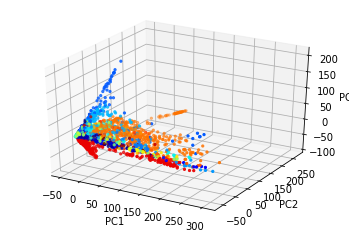

In [41]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(last_pca[:,0],last_pca[:,1], last_pca[:,3], marker=".", c=y_train_vec, cmap=cmap)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

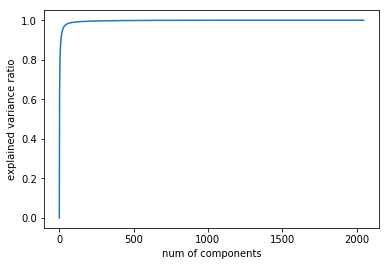

In [42]:
pca.fit(last_feature)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# grad-cam

In [43]:
from tensorflow.keras.preprocessing import image

In [44]:
true = []
for i in range(num_s_class):
    true.append(i)

In [61]:
pred = []

grad_last_conv = full_model.get_layer("mixed10")
model_output = full_model.output[:,0]
grads = K.gradients(model_output, grad_last_conv.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([full_model.input], [pooled_grads, grad_last_conv.output[0]])

for n in range(len(grad_test_img_path)):
    img_keras = image.load_img(grad_test_img_path[n], target_size=(224, 224))
    img_tensor = image.img_to_array(img_keras)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    predicts = full_model.predict(img_tensor)
    s_class_num = np.argmax(predicts)
    pred.append(s_class_num)
    img_tensor /= 255.
    pooled_grads_val, conv_output_val = iterate([img_tensor]) # pooled_grads_val or conv_output_val under 0
    for i in range(pooled_grads_val.shape[0]):
        conv_output_val[:, :, i] *= pooled_grads_val[i]
    heatmap = np.mean(conv_output_val, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    print(np.max(heatmap))
    heatmap /= np.max(heatmap) #<- np.max(heatmap)=0 causes problem
    img = cv2.imread(grad_test_img_path[n])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    save_dir = '../data/gradcam_img/InceptionV3/'+s_classlist[n]
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)	# Make a directory
    #保存先ディレクトリ名はその画像のクラス，画像の予測値を画像の名前に書き込む
    cv2.imwrite(save_dir+'/heatmap_pred_'+s_classlist[s_class_num]+'.jpg', superimposed_img)
    print('Saved: ', save_dir+'/heatmap_pred_'+s_classlist[s_class_num]+'.jpg')

0.0
Saved:  ../data/gradcam_img/InceptionV3/4gokan_inside/heatmap_pred_5gokan_ent_east.jpg


/home/tamaru/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


2.5711532e-19
Saved:  ../data/gradcam_img/InceptionV3/4gokan_outside/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan-denkisogokan/heatmap_pred_5gokan_ent_east.jpg
5.1075664e-13
Saved:  ../data/gradcam_img/InceptionV3/5gokan-mediacenter/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_1F/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_2F/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_3F/heatmap_pred_5gokan_ent_east.jpg
2.7894622e-13
Saved:  ../data/gradcam_img/InceptionV3/5gokan_ent_east/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_lounge/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_out_east/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_parking/heatmap_pred_5gokan_ent_east.jpg
0.0
Saved:  ../data/gradcam_img/InceptionV3/5gokan_smok

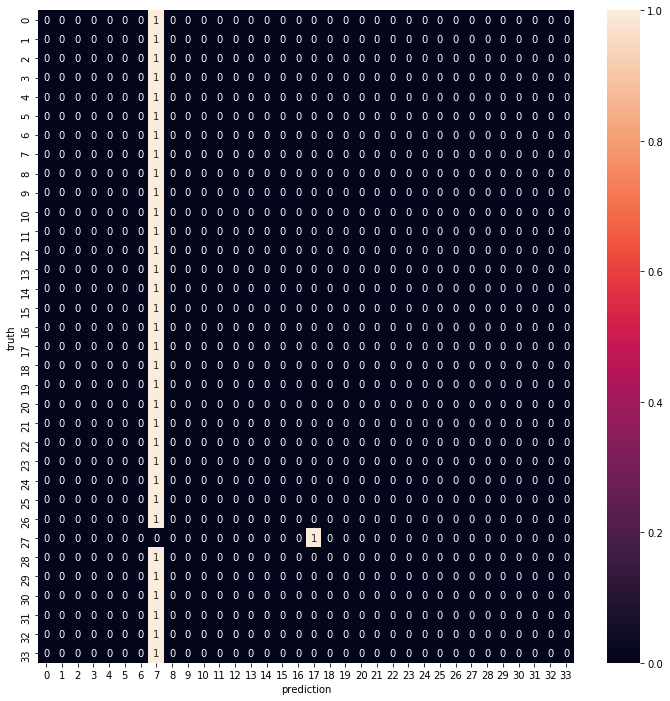

In [59]:
cmx = confusion_matrix(true, pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.ylabel("truth")
plt.xlabel("prediction")
plt.show()

In [60]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

                      s_class
0           ['4gokan_inside']
1          ['4gokan_outside']
2     ['5gokan-denkisogokan']
3      ['5gokan-mediacenter']
4               ['5gokan_1F']
5               ['5gokan_2F']
6               ['5gokan_3F']
7         ['5gokan_ent_east']
8           ['5gokan_lounge']
9         ['5gokan_out_east']
10         ['5gokan_parking']
11         ['5gokan_smoking']
12      ['5gokan_stairs_cnt']
13     ['5gokan_stairs_west']
14              ['8gokan_1F']
15       ['8gokan_ent_north']
16       ['8gokan_ent_south']
17        ['denkisogokan_2F']
18        ['denkisogokan_3F']
19        ['denkisogokan_4F']
20  ['denkisogokan_elevator']
21    ['denkisogokan_lounge']
22    ['denkisogokan_stairs']
23             ['lab-lounge']
24             ['lab_bs_cnt']
25             ['lab_corner']
26               ['lab_desk']
27         ['lab_desk_table']
28                ['lab_ent']
29            ['lab_printer']
30              ['lab_table']
31             ['lab_wb_cnt']
32        

grad cam
last convolutional layer -> X conv2d_94
                            O mixed10
mixed = convolutional layer including branch architecture

inception cannnot use gradcam??